<a href="https://colab.research.google.com/github/MrEminent42/wordle-ai/blob/Nov-2022/WordleAI_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## WordleGame

In [188]:
from enum import IntEnum
from termcolor import colored

def debug(*info):
  p = False
  if p: print(info)

class WordleGame:
    def __init__(self, answer):
        self.answer = answer.upper()
        self.board = []
        self.is_over = False
        self.win = False

    def __repr__(self):
        s = ""
        # in each line
        for i, line in enumerate(self.board):
            colors = self.get_colors(self.get_line_string(i))
            for i, tile in enumerate(line):
                # for i, char in enumerate(line):
                s += (
                    colored(tile.char, "white")
                    if tile.color == Color.GREY
                    else (
                        colored(tile.char, "magenta")
                        if tile.color == Color.YELLOW
                        else colored(tile.char, "green")
                    )
                )
            s += "\n"

        return s

    def guess(self, guess):
        """Takes a five-letter guess, records this guess on the game's board.
        Returns the array of Colors with each index corresponding to the color of the letter at that index in the guess"""
        tiles = []
        if len(guess) != 5:
            raise ValueError(
                'Wordle guess must be a 5-letter word. Could not guess with word "'
                + guess
                + '".'
            )
        # convert everything to upper case
        guess = guess.upper()
        # debug print
        debug("Your guess:", guess)
        debug("The answer:", self.answer)
        colors = self.get_colors(guess)
        # log guess to board
        tiles = [Tile(guess[i], colors[i]) for i in range(5)]
        self.board.append(tiles)

        # check for game over
        if len(self.board) >= 6:
            self.is_over = True
        elif guess == self.answer:
            print("WIN!")
            self.is_over = self.win = True

        # give back list of colors
        return colors

    def get_colors(self, guess):
        """Takes in a five-letter guess, returns an array of Colors with
        each index corresponding to the color of the letter at that index in the guess."""
        if len(guess) != 5:
            raise ValueError(
                'Can only find colors for words of length 5. Could not find colors for word "'
                + guess
                + '"'
            )
        colors = []
        # occurrences_left = {char: self.answer.count(char) for char in self.answer}
        occurrences_left = {}
        # more efficient way of counting num occurences
        for char in self.answer:
            if char in occurrences_left:
                occurrences_left[char] += 1
            else:
                occurrences_left[char] = 1

        for i, char in enumerate(guess):
            # if the character is in the correct place, green
            if self.answer[i] == char:
                colors.append(Color.GREEN)
                occurrences_left[char] -= 1
                debug("Green:", char)
            # if the character is in the word, but in the wrong place
            elif char in self.answer:
                # if there are stil occurences of this char that have not been accounted for
                if occurrences_left[char] > 0:
                    # append a yellow tile
                    colors.append(Color.YELLOW)
                    debug("Yellow:", char)
                    # record that we have accounted for this occurence
                    occurrences_left[char] -= 1
                else:
                    colors.append(Color.GREY)
                    debug("Grey:", char)
            else:
                colors.append(Color.GREY)
                debug("Grey:", char)

        return colors

    def get_line_string(self, i):
        s = ""
        for tile in self.board[i]:
            s += tile.char
        return s

    def is_over(self):
        return self.is_over

    def run_game(self):
        print("Welcome to Wordle-AI!")
        while not self.is_over:
            self.guess(input("Guess: "))
            print(self)
        if self.win:
            print("Congrats! You found the word in " + str(len(self.board)) + " tries.")
        else:
            print("Darn! You didn't find the word. It was " + self.answer + ".")


class Color(IntEnum):
    GREY = GRAY = 0
    YELLOW = 1
    GREEN = 2


class Tile:
    def __init__(self, character, color):
        self.char = character
        self.color = color

## DQN
Based on https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

### TF Setup

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

### Gym setup

In [ ]:
!pip install "gym>=0.21.0"

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

import random

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

#### Wordle Data Setup

In [132]:
import requests
import io

import urllib.request
import os
from os import path

In [185]:
# raw_data_source = "https://raw.githubusercontent.com/tabatkins/wordle-list/main/words"
raw_data_source = "https://pastebin.com/raw/cLhVJ29Y"
directory_name = "WordleData"
file_name = "wordList.txt"


def retrieve_data():
    url_request = urllib.request.urlopen(raw_data_source)
    data = url_request.read().decode("utf-8")
    return data


def store_data():
    if os.path.isfile(get_file_path()) == False:
        data = retrieve_data()
        os.mkdir(directory_name)
        file = open(get_file_path(), "w")
        file.write(data)
        file.close


def get_file_path():
    return path.join(directory_name, file_name)


In [191]:
store_data()

find_word = {}
find_num = {}

with open(get_file_path()) as f:
  words = f.read().splitlines()

for i in range(len(words)):
  find_word[i] = words[i]
  find_num[words[i]] = i

num_words = len(find_word)
num_words

9

### Environment
Based on https://www.tensorflow.org/agents/tutorials/2_environments_tutorial#creating_your_own_python_environment

In [189]:
wordle_rows = 6 # @param {type:"integer"}
wordle_cols = 5  # @param {type:"integer"}
wordle_colors = 3  # @param {type:"integer"}

english_letters = 26  # @param {type:"integer"}

win_bonus = 25 # @param {type:"integer"}

In [190]:
import random

def get_observation_array(game):
  obs = np.zeros((wordle_rows * wordle_cols, english_letters, wordle_colors), dtype=np.int32)
  # for every tile on the board
  for row in range(len(game.board)):
    for col in range(len(game.board[row])):
      char = game.board[row][col].char
      color = game.board[row][col].color
      obs[row * 5 + col,ord(char) - 65,int(color)] = 1

  return obs

def get_reward(game):
  sum = 0
  # for row in game.board:
  #   for tile in row:
  #     sum += int(tile.color) + 1
  # for row in game.board:
  if len(game.board) == 0: return 0
  for tile in game.board[len(game.board) - 1]:
    sum += int(tile.color) + 1
  if game.win: sum += win_bonus
  return sum * ((10 - len(game.board))/10)
  # return np.array([sum], dtype=np.int32)

In [161]:
class WordleEnvironment(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=num_words - 1, name='action'
    )
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(wordle_rows * wordle_cols, english_letters, wordle_colors), dtype=np.int32, minimum=0, maximum=1, name='observation'
    )
    
    self.game = WordleGame(find_word[random.randint(0,num_words - 1)])

  def action_spec(self):
    return self._action_spec
  
  def observation_spec(self):
    return self._observation_spec
  
  def _reset(self):
    self.game = WordleGame(find_word[random.randint(0,num_words - 1)])
    return ts.restart(get_observation_array(self.game)) # TODO update

  def _step(self, action):
    debug("stepped")
    debug("ACTION:", int(action))
    if self.game.is_over: 
      debug("resetting")
      return self.reset()

    # perform the action 
    colors = self.game.guess(find_word[int(action)])

    # return the observation state
    # if the game is now over
    if self.game.is_over:
      debug("terminating")
      return ts.termination(get_observation_array(self.game), reward=get_reward(self.game))
    
    return ts.transition(get_observation_array(self.game), reward=get_reward(self.game), discount=1.0)

  def _current_time_step(self):
    return len(self.game.board)

#### test the environment

In [ ]:
import random
testing_env = WordleEnvironment()
time_step = testing_env.reset()
# print(time_step)
while not time_step.is_last():
  time_step = testing_env.step(np.array(random.randint(0, num_words - 1), dtype=np.int32))
  print(time_step)

In [193]:
# test the observation spec
# game = WordleGame(find_word[random.randint(0,num_words - 1)])
game = WordleGame("LATER")
game.guess("LATER")
print("Answer: ", game.answer)
obs = get_observation_array(game)
print("Tile 0 [L]: ", obs[0][ord("L")-65])
print("Tile 1 [A]: ", obs[1][ord("A")-65])
print("Tile 2 [T]: ", obs[2][ord("T")-65])
print("Tile 3 [E]: ", obs[3][ord("E")-65])
print("Tile 4 [R]: ", obs[4][ord("R")-65])

print("Current reward:", get_reward(game))

WIN!
Answer:  LATER
Tile 0 [L]:  [0 0 1]
Tile 1 [A]:  [0 0 1]
Tile 2 [T]:  [0 0 1]
Tile 3 [E]:  [0 0 1]
Tile 4 [R]:  [0 0 1]
Current reward: 36.0


#### Convert to TF Environment

In [ ]:
tf_env = tf_py_environment.TFPyEnvironment(WordleEnvironment())

print(isinstance(tf_env, tf_environment.TFEnvironment))
print("TimeStep Specs:", tf_env.time_step_spec())
print("Action Specs:", tf_env.action_spec())

True
TimeStep Specs: TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': BoundedTensorSpec(shape=(30, 26, 3), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(14854, dtype=int32))


### Training

##### training parameters

In [194]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 200  # @param {type:"integer"}

In [195]:
# convert to TF Environment
train_py_env = WordleEnvironment()
eval_py_env = WordleEnvironment()

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


#### training debug info

In [ ]:
print('Observation Spec:')
print(train_py_env.time_step_spec().observation)
print('Reward Spec:')
print(train_py_env.time_step_spec().reward)
print('Action Spec:')
print(train_py_env.action_spec())

print('action_spec:', train_py_env.action_spec())
print('time_step_spec.observation:', train_py_env.time_step_spec().observation)
print('time_step_spec.step_type:', train_py_env.time_step_spec().step_type)
print('time_step_spec.discount:', train_py_env.time_step_spec().discount)
print('time_step_spec.reward:', train_py_env.time_step_spec().reward)


Observation Spec:
BoundedArraySpec(shape=(30, 26, 3), dtype=dtype('int32'), name='observation', minimum=0, maximum=1)
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=14854)
action_spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=14854)
time_step_spec.observation: BoundedArraySpec(shape=(30, 26, 3), dtype=dtype('int32'), name='observation', minimum=0, maximum=1)
time_step_spec.step_type: ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')
time_step_spec.discount: BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)
time_step_spec.reward: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [ ]:
print('Observation Spec:')
print(eval_py_env.time_step_spec().observation)
print('Reward Spec:')
print(eval_py_env.time_step_spec().reward)
print('Action Spec:')
print(eval_py_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(30, 26, 3), dtype=dtype('int32'), name='observation', minimum=0, maximum=1)
Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')
Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=14854)


### Agent

In [196]:
layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
num_actions

9

In [197]:
# helper method for creating a bunch of dense layers
def make_dense_layer(units):
  return tf.keras.layers.Dense(
      units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'
      )
  )

# create DQN 
dense_layers = [make_dense_layer(units) for units in layer_params]
q_vals_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03
    ),
    bias_initializer=tf.keras.initializers.Constant(-0.2)
)

q_net = sequential.Sequential([tf.keras.layers.Flatten()] + dense_layers + [q_vals_layer])

In [198]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)

agent.initialize()

### Policies

In [199]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

#### random policy

In [200]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())
eval_policy = agent.policy
collect_policy = agent.collect_policy

train_env.time_step_spec().observation.shape, train_env.time_step_spec().observation.shape, random_policy.time_step_spec.observation.shape

time2 = train_env.reset()

random_policy.action(time2)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([6], dtype=int32)>, state=(), info=())

### Metrics & Evaluaion

In [201]:
def compute_avg_return(environment, policy, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

#### test metrics

In [205]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

WIN!
WIN!
WIN!
WIN!


31.690002

### Replay Buffer

In [204]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size = replay_buffer_max_length,
    sampler = reverb.selectors.Uniform(),
    remover = reverb.selectors.Fifo(),
    rate_limiter = reverb.rate_limiters.MinSize(1),
    signature = replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name = table_name,
    sequence_length = 2,
    local_server = reverb_server
)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2
)

### Data Collection

In [ ]:
env = WordleEnvironment()
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True
    ),
    [rb_observer],
    max_steps=initial_collect_steps
).run(train_py_env.reset())

In [207]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls = 3,
    sample_batch_size = batch_size,
    num_steps = 2
).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 30, 26, 3), dtype=tf.int32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [208]:
iterator = iter(dataset)
print(iterator)

### Training the agent!

In [ ]:
try: 
  %% time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# reset train step
agent.train_step_counter.assign(0)

# eval agent's policy once before training
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# reset environment
time_step = train_py_env.reset()

# create a driver to collect experience
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True
    ),
    [rb_observer],
    max_steps=collect_steps_per_iteration
)

# train!
for _ in range(num_iterations):
  # collect some steps to save into replay buffer
  time_step, _ = collect_driver.run(time_step)

  #sample a batch of data from the buffer, update the agent's network
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss
  
  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print("step = {0}: loss = {1}".format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

(25.996997451782228, 75.0)

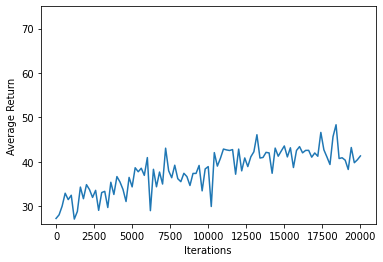

In [211]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=75)

#### Manual Test

In [253]:
custom_py_env = WordleEnvironment()
# custom_py_env.game = WordleGame("seize");
custom_env = tf_py_environment.TFPyEnvironment(custom_py_env)


# print("Game word:", custom_env.game.answer)
# print("Init reward:", get_reward(custom_env.game))

step = custom_env.reset()

# 2693 = HELPS
# helps = custom_env.step(np.array([2693], dtype=np.int32));
# helps = custom_env.step(np.array([find_num["seize"]], dtype=np.int32));

# print("Reward after SEIZE:", get_reward(custom_env.game))

# print(agent.policy.action(custom_env))




next_number = np.array(agent.policy.action(step).action)[0]
next_word = find_word[next_number]
# next_word = 'hello'
# next_number = find_num[next_word]
print("guess word:", next_word)
time3 = custom_env.step(np.array([next_number], dtype=np.int32));
# print("reward after that word:",get_reward(custom_env.game))


next_number = np.array(agent.policy.action(time3).action)[0]
next_word = find_word[next_number]
# next_word = 'hello'
# next_number = find_num[next_word]
print("guess word:", next_word)
time3 = custom_env.step(np.array([next_number], dtype=np.int32));



next_number = np.array(agent.policy.action(time3).action)[0]
next_word = find_word[next_number]
# next_word = 'hello'
# next_number = find_num[next_word]
print("guess word:", next_word)
time3 = custom_env.step(np.array([next_number], dtype=np.int32));



next_number = np.array(agent.policy.action(time3).action)[0]
next_word = find_word[next_number]
# next_word = 'hello'
# next_number = find_num[next_word]
print("guess word:", next_word)
time3 = custom_env.step(np.array([next_number], dtype=np.int32));



next_number = np.array(agent.policy.action(time3).action)[0]
next_word = find_word[next_number]
# next_word = 'hello'
# next_number = find_num[next_word]
print("guess word:", next_word)
time3 = custom_env.step(np.array([next_number], dtype=np.int32));


next_number = np.array(agent.policy.action(time3).action)[0]
next_word = find_word[next_number]
# next_word = 'hello'
# next_number = find_num[next_word]
print("guess word:", next_word)
time3 = custom_env.step(np.array([next_number], dtype=np.int32));



guess word: lefts
guess word: sneak
guess word: lefts
guess word: seize
WIN!
guess word: seize
guess word: lefts
